# Clustering in PySpark's MLlib Project

**Project Title:** University Clustering for the Greater Good

**Objective**

You are a data scientist employed by the ABCDE Foundation, a non-profit organization whose mission is to increase college graduation rates for underpriveleged populations. Through advocacy and targeted outreach programs, ABCDE strives to identify and alleviate barriers to educational achievement. ABCDE is driven by the belief that with the right supports, an increase in college attendance and completion rates can be achieved, thereby weakening the grip of the cycles of poverty and social immobility affecting many of our communities.

ABCDE is committed to developing a more data driven approach to decision making. As a prelude to future analyses, ABCDE has requested that you analyze the data to identify clusters of similar colleges and universities.

**Your Task**

Use cluster analysis to identify the groups of characteristically similar schools in the CollegeScorecard.csv dataset. A few questions are outlined below to help guide you. 

## Considerations:

 - Data Preparation 
 - How will you deal with missing values? 
 - Are there any categorical variables in the dataset? How will you deal with those? 
 - Consider experiementing with hyperparameter optimization techniques

These are the (sometimes subjective) questions you need to figure out as a data scientist. It's highly recommended that you familiarize yourself with the dataset's dictionary and documentation (see "Data Dictionary description below), as well as the theory and technical characteristics of the algorithm(s) you're using.

**Interpretation**

Is it possible to explain what each cluster represents? Did you retain or prepare a set of features that enables a meaningful interpretation of the clusters? Do the compositions of the clusters seem to make sense?

**Validation**

How will you measure the validity of your clustering process? Which metrics will you use and how will you apply them?

*Important Note:*

This is an open-ended assignment (as many or most real-life data science projects are). Your only constraints are that you must use the data provided, execute high-quality and justifiable clustering technique, provide your rationale for the decisions you made, and ultimately produce meaningful cluster labels. Three questions have been provided below to help get you started and provide some direction for your analysis, but feel free to explore the dataset in your own unique way and share it with the class! The sky is the limit!

**Source:** https://data.world/exercises/cluster-analysis-exercise-2

**Data:** CollegeScorecard.csv <br>
**Data Dictionary:** CollegeScoreCardDataDictionary-09-12-2015.csv

In [1]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("LDA").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
appid = spark._jsc.sc().applicationId()
print("You are working with", cores, "core(s) on appid: ",appid)
spark

You are working with 1 core(s) on appid:  local-1621987931144


In [2]:
# Read in dependencies
# import string
from pyspark.sql.types import *

# from pyspark import SparkContext
# from pyspark.sql import SQLContext
# from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import *
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import *

# For pipeline development in case you need it (but we won't use it here)
from pyspark.ml import Pipeline 

In [3]:
path ="Datasets/"
df = spark.read.csv(path+'CollegeScorecard.csv',inferSchema=True,header=True)

In [4]:
df.limit(5).toPandas()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385


In [8]:
df.printSchema()

root
 |-- UNITID: integer (nullable = true)
 |-- OPEID: integer (nullable = true)
 |-- opeid6: integer (nullable = true)
 |-- INSTNM: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STABBR: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- AccredAgency: string (nullable = true)
 |-- INSTURL: string (nullable = true)
 |-- NPCURL: string (nullable = true)
 |-- sch_deg: string (nullable = true)
 |-- HCM2: integer (nullable = true)
 |-- main: integer (nullable = true)
 |-- NUMBRANCH: integer (nullable = true)
 |-- PREDDEG: integer (nullable = true)
 |-- HIGHDEG: integer (nullable = true)
 |-- CONTROL: integer (nullable = true)
 |-- st_fips: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- LOCALE: integer (nullable = true)
 |-- locale2: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- CCBASIC: integer (nullable = true)
 |-- CCUGPROF: integer (nullable = true)
 |-- CCSIZSET: in

In [9]:
df.count() # no of rows

7804

### Check the missing values

In [10]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+------------+-----------------+------------------+
| Column_Name|Null_Values_Count|Null_Value_Percent|
+------------+-----------------+------------------+
|AccredAgency|             2052| 26.29420809841107|
|     INSTURL|               85| 1.089185033316248|
|      NPCURL|              591|  7.57303946694003|
|     sch_deg|             7804|             100.0|
|      LOCALE|              424| 5.433111225012814|
|     locale2|             7804|             100.0|
|    LATITUDE|              785|10.058944131214762|
|   LONGITUDE|              785|10.058944131214762|
|     CCBASIC|             3449| 44.19528446950282|
|    CCUGPROF|             4245| 54.39518195797027|
|    CCSIZSET|             4228| 54.17734495130703|
|        HBCU|              421| 5.394669400307535|
|         PBI|              421| 5.394669400307535|
|       ANNHI|              421| 5.394669400307535|
|      TRIBAL|              421| 5.394669400307535|
|     AANAPII|              421| 5.394669400307535|
|         HS

### Fill in null values with average

In [5]:
columns = [item[0] for item in df.dtypes if not item[1].startswith('string')]
columns

['UNITID',
 'OPEID',
 'opeid6',
 'HCM2',
 'main',
 'NUMBRANCH',
 'PREDDEG',
 'HIGHDEG',
 'CONTROL',
 'st_fips',
 'region',
 'LOCALE',
 'LATITUDE',
 'LONGITUDE',
 'CCBASIC',
 'CCUGPROF',
 'CCSIZSET',
 'HBCU',
 'PBI',
 'ANNHI',
 'TRIBAL',
 'AANAPII',
 'HSI',
 'NANTI',
 'MENONLY',
 'WOMENONLY',
 'RELAFFIL',
 'ADM_RATE',
 'ADM_RATE_ALL',
 'SATVR25',
 'SATVR75',
 'SATMT25',
 'SATMT75',
 'SATWR25',
 'SATWR75',
 'SATVRMID',
 'SATMTMID',
 'SATWRMID',
 'ACTCM25',
 'ACTCM75',
 'ACTEN25',
 'ACTEN75',
 'ACTMT25',
 'ACTMT75',
 'ACTWR25',
 'ACTWR75',
 'ACTCMMID',
 'ACTENMID',
 'ACTMTMID',
 'ACTWRMID',
 'SAT_AVG',
 'SAT_AVG_ALL',
 'PCIP01',
 'PCIP03',
 'PCIP04',
 'PCIP05',
 'PCIP09',
 'PCIP10',
 'PCIP11',
 'PCIP12',
 'PCIP13',
 'PCIP14',
 'PCIP15',
 'PCIP16',
 'PCIP19',
 'PCIP22',
 'PCIP23',
 'PCIP24',
 'PCIP25',
 'PCIP26',
 'PCIP27',
 'PCIP29',
 'PCIP30',
 'PCIP31',
 'PCIP38',
 'PCIP39',
 'PCIP40',
 'PCIP41',
 'PCIP42',
 'PCIP43',
 'PCIP44',
 'PCIP45',
 'PCIP46',
 'PCIP47',
 'PCIP48',
 'PCIP49',
 'P

In [12]:
df.select(columns).summary("count", "min", "25%", "75%", "max").toPandas()

,summary,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,...,RET_PT4,RET_PTL4,C200_4_POOLED,C200_L4_POOLED,poolyrs200,D200_4_POOLED,D200_L4_POOLED,PCTFLOAN,UG25abv,CDR3
0,count,7804,7804,7804,7804,7804,7804,7804,7804,7804,...,1468,2264,2160,3794,5954,2160,3794,7063,7031,7742
1,min,100654,100200,1002,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,2,1,2,0.0,5.0E-4,0.0
2,25%,174385,345400,3438,0,0,1,1,1,1,...,0.25,0.381,0.333806456,0.389701471,2,148,91,0.3424,0.2528,0.05
3,75%,446224,2616704,25782,0,1,3,3,4,3,...,0.6343,0.7625,0.640230488,0.778434091,2,1352,847,0.757,0.5833,0.195
4,max,48285707,82098821,42264,1,1,141,4,4,3,...,1.0,1.0,1.0,1.0,4,14713,29954,1.0,1.0,1.0


In [6]:
from pyspark.sql.functions import *
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    return df.na.fill(stats.first().asDict())
df = fill_with_mean(df, columns)
df = df.select(columns)
df.limit(5).toPandas()

,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,...,RET_PT4,RET_PTL4,C200_4_POOLED,C200_L4_POOLED,poolyrs200,D200_4_POOLED,D200_L4_POOLED,PCTFLOAN,UG25abv,CDR3
0,100654,100200,1002,0,1,1,3,4,1,1,...,0.5000,0.558225,0.351686,0.593543,2,2286,687,0.8204,0.1049,0.163
1,100663,105200,1052,0,1,1,3,4,1,1,...,0.5000,0.558225,0.473092,0.593543,2,3046,687,0.5397,0.2422,0.080
2,100690,2503400,25034,0,1,1,3,4,2,1,...,0.3333,0.558225,0.333314,0.593543,4,21,687,0.7629,0.8540,0.089
3,100706,105500,1055,0,1,1,3,4,1,1,...,0.4444,0.558225,0.494129,0.593543,2,1279,687,0.4728,0.2640,0.077
4,100724,100500,1005,0,1,1,3,4,1,1,...,0.3023,0.558225,0.293652,0.593543,2,2336,687,0.8735,0.1270,0.191


### Convert all input columns (features) into a vector

In [7]:
from pyspark.ml.feature import VectorAssembler
input_columns = columns # Collect the column names as a list
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df) #.select('CUST_ID', 'features')
df_kmeans.limit(4).toPandas()

,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,...,RET_PTL4,C200_4_POOLED,C200_L4_POOLED,poolyrs200,D200_4_POOLED,D200_L4_POOLED,PCTFLOAN,UG25abv,CDR3,features
0,100654,100200,1002,0,1,1,3,4,1,1,...,0.558225,0.351686,0.593543,2,2286,687,0.8204,0.1049,0.163,"(100654.0, 100200.0, 1002.0, 0.0, 1.0, 1.0, 3...."
1,100663,105200,1052,0,1,1,3,4,1,1,...,0.558225,0.473092,0.593543,2,3046,687,0.5397,0.2422,0.080,"(100663.0, 105200.0, 1052.0, 0.0, 1.0, 1.0, 3...."
2,100690,2503400,25034,0,1,1,3,4,2,1,...,0.558225,0.333314,0.593543,4,21,687,0.7629,0.8540,0.089,"(100690.0, 2503400.0, 25034.0, 0.0, 1.0, 1.0, ..."
3,100706,105500,1055,0,1,1,3,4,1,1,...,0.558225,0.494129,0.593543,2,1279,687,0.4728,0.2640,0.077,"(100706.0, 105500.0, 1055.0, 0.0, 1.0, 1.0, 3...."


### K-means

In [17]:
# Find the best amount of clusters
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# set a max for the number of clusters you want to try out
kmax = 10
# Create and array filled with zeros for the amount of k
# Similar to creating an empty list
kmcost = np.zeros(kmax)
for k in range(2,kmax):
    # Set up the k-means alogrithm
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    # Fit it on your dataframe
    model = kmeans.fit(df_kmeans)
    # Fill in the zeros of your array with cost....
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    # For Spark 2.0 to 3.0
#     kmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions) #computing Silhouette score

Text(0, 0.5, 'cost')

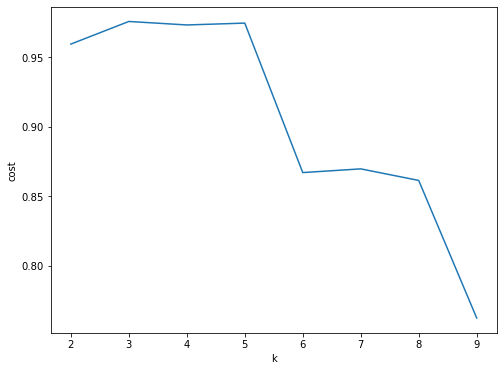

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the plot dimensions
fig, ax = plt.subplots(1,1, figsize =(8,6))
# Then specify the range of values for the axis and call on your cost array
ax.plot(range(2,kmax),kmcost[2:kmax])
# Set up the axis labels
ax.set_xlabel('k')
ax.set_ylabel('cost')

### Bisecting k-means

In [9]:
from pyspark.ml.clustering import BisectingKMeans
import numpy as np
# Same calls here except with bkmeans
kmax = 20
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = bkmeans.fit(df_kmeans)
    
    # For Spark > 2.0 AND Spark < 3.0
#     bkmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

NameError: name 'ClusteringEvaluator' is not defined

Text(0, 0.5, 'cost')

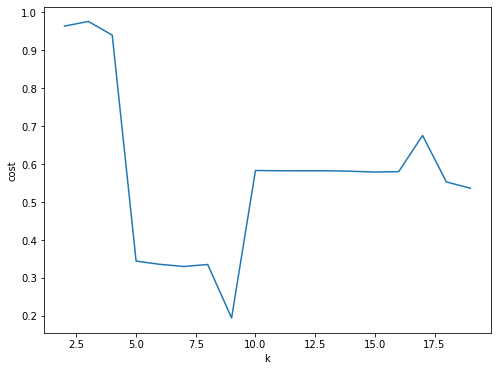

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

## Describe the clusters in lamens terms

What are some defining characteristics of each cluster? Try to use some of the variables to explain to the client. 

In [36]:
# First get the centers of each cluster
centers = bkmeans.clusterCenters()

# Then map the centers to their variable names
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = input_columns
center_pdf

AttributeError: 'BisectingKMeans' object has no attribute 'clusterCenters'

## How many Universities are in each cluster?

## List the Universities by Cluster